# Setup path directory

1.   import library
2.   Setup Path



## Import Library

In [1]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
import random
import pprint
import sys
import time
import numpy as np
from optparse import OptionParser
import pickle
import math
import cv2
import copy
from matplotlib import pyplot as plt
import tensorflow as tf
import pandas as pd
import os
import keras

from sklearn.metrics import average_precision_score
from keras import backend as K
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.objectives import categorical_crossentropy

from skimage import io 

from keras.models import Model
from keras.utils import generic_utils
from keras.engine.topology import Layer, InputSpec
from keras import initializers, regularizers

## Setup Config

In [2]:
class Config:

  def __init__(self):
    # Print the process or not
    self.verbose = True
    # Name of base network
    self.network = 'vgg'
    # Setting for data augmentation
    self.use_horizontal_flips = False
    self.use_vertical_flips = False
    self.rot_90 = False

    # Anchor box scales
    # Note that if im_size is smaller, anchor_box_scales should be scaled
    # Original anchor_box_scales in the paper is [128, 256, 512]
    self.anchor_box_scales = [64, 128, 256] 
    # Anchor box ratios
    self.anchor_box_ratios = [[1, 1], [1./math.sqrt(2), 2./math.sqrt(2)], [2./math.sqrt(2), 1./math.sqrt(2)]]

    # Size to resize the smallest side of the image
    # Original setting in paper is 600. Set to 300 in here to save training time
    self.im_size = 300

    # image channel-wise mean to subtract
    self.img_channel_mean = [103.939, 116.779, 123.68]
    self.img_scaling_factor = 1.0

    # number of ROIs at once
    self.num_rois = 4

    # stride at the RPN (this depends on the network configuration)
    self.rpn_stride = 16

    self.balanced_classes = False

    # scaling the stdev
    self.std_scaling = 4.0
    self.classifier_regr_std = [8.0, 8.0, 4.0, 4.0]

    # overlaps for RPN
    self.rpn_min_overlap = 0.3
    self.rpn_max_overlap = 0.7

    # overlaps for classifier ROIs
    self.classifier_min_overlap = 0.1
    self.classifier_max_overlap = 0.5

    # placeholder for the class mapping, automatically generated by the parser
    self.class_mapping = None
    self.model_path = None
    self.base_weights_path = None

In [3]:
config = Config()
config.use_horizontal_flips = True
config.use_vertical_flips = True
config.rot_90 = True

## Import Path

In [4]:
base_path = ''
data_path = os.path.join(base_path,'data')
train_path = os.path.join(data_path,'preprocessing/train.csv')
output_weight_path = os.path.join(base_path,'model/model_faster_rcnn.h5')
base_weights_path   = os.path.join(base_path,'model/vgg16_weights_tf_dim_ordering_tf_kernels.h5')
record_path = os.path.join(base_path,'model/record.csv')
config_output_filename = os.path.join(base_path, 'config/model_vgg_config.pickle')

Save path to config

In [5]:
config.record_path = record_path
config.model_path  = output_weight_path
config.base_net_weights = base_weights_path

# Read data from path

In [6]:
def get_data(csv_path):
  """
  parse the data from annotation file
  Input:
    csv_path: image csv file
  Output:
    all_data: "filepath, width , height, list(bboxes)
    Class_count
    Class_mapping
  """
  data = pd.read_csv(csv_path)
  all_imgs = {}
  classes_count = {}
  class_mapping = {}
  found_bg = False
  path = 'data/train'
  for i, row in data.iterrows():
    # sys.stdout.write(str(i) + ', image: ' +str(row['FileName']) + '\r')
    # sys.stdout.flush()
    img_fname = row['FileName']
    img_path = os.path.join(path, img_fname)
    img = io.imread(img_path)
    height, width = img.shape[:2]
    ## Note that the coordinate of cv2
    #  0, 0 --------------------------->
    #   |   x1, y1 --------------
    #   |       |
    #   |       |
    #   v       -----------------x2, y2
    class_name = row['ClassName']
    x1 = int (row['XMin'] * width)
    x2 = int (row['XMax'] * width)
    y1 = int (row['YMin'] * height)
    y2 = int (row['YMax'] * height)
    if class_name not in classes_count:
      classes_count[class_name] = 1
    else:
      classes_count[class_name]  += 1
    if class_name not in class_mapping:
      if class_name == 'bg' and found_bg == False:
        print('We have background region in data')
        found_bg = True
      class_mapping[class_name] = len(class_mapping)
    if img_fname not in all_imgs:
      all_imgs[img_fname] = {}
      all_imgs[img_fname]['filepath'] = img_path
      all_imgs[img_fname]['width'] = width
      all_imgs[img_fname]['height'] = height
      all_imgs[img_fname]['bboxes'] = []
    all_imgs[img_fname]['bboxes'].append({'class': class_name,
                                        'x1': x1,
                                        'x2': x2,
                                        'y1': y1,
                                        'y2': y2})

  all_data = []
  for key in all_imgs:
      all_data.append(all_imgs[key])    
  return all_data, classes_count,class_mapping

In [7]:
all_data, classes_count,class_mapping = get_data(train_path)

In [8]:
if 'bg' not in classes_count:
	classes_count['bg'] = 0
	class_mapping['bg'] = len(class_mapping)
# e.g.
#    classes_count: {'Car': 2383, 'Mobile phone': 1108, 'Person': 3745, 'bg': 0}
#    class_mapping: {'Person': 0, 'Car': 1, 'Mobile phone': 2, 'bg': 3}
config.class_mapping = class_mapping

print('Training images per class:')
pprint.pprint(classes_count)
print('Num classes (including bg) = {}'.format(len(classes_count)))
print(class_mapping)


Training images per class:
{'Car': 964, 'Mobile phone': 559, 'Person': 2215, 'bg': 0}
Num classes (including bg) = 4
{'Person': 0, 'Car': 1, 'Mobile phone': 2, 'bg': 3}


Save config to test

In [9]:
with open(config_output_filename, 'wb') as config_f:
  pickle.dump(config,config_f)
  print('Config has been written to {}, and can be loaded when testing to ensure correct results'.format(config_output_filename))

Config has been written to config/model_vgg_config.pickle, and can be loaded when testing to ensure correct results


In [10]:
# Shuffle the images with seed
random.seed(1)
random.shuffle(all_data)

print('Num train samples (images) {}'.format(len(all_data)))

Num train samples (images) 1138


# Creat anchor for all images

## Calculate IOU

In [11]:
def intersection(bbox, abox):
  '''
  Calculate intersection of anchor box and bounding box
  Input:
    bbox is array which contains coordinates of bounding box
    abox is array which contains coordinates of anchor box
  Output:
    intersection of anchor box and bounding box
  '''
  x1 = max(bbox[0], abox[0])
  x2 = min(bbox[1], abox[1])
  y1 = max(bbox[2], abox[2])
  y2 = min(bbox[3], abox[3])
  inters = (x2 - x1) * (y2 - y1)
  if (x2 - x1) < 0 or (y2 - y1) < 0:
    return 0.0
  else:
    return inters 

def union(bbox, abox, inters):
  '''
  Calculate union of anchor box and bounding box
  Input:
    bbox is array which contains coordinates of bounding box
    abox is array which contains coordinates of anchor box
    Inter is intersection of anchor box and bounding box
  Output:
    union of anchor box and bounding box
  '''
  a_area = (abox[1] - abox[0]) * (abox[3] - abox[2]) # anchor box area
  b_area = (bbox[1] - bbox[0]) * (bbox[3] - bbox[2]) # bounding box area
  uni = a_area + b_area - inters
  return uni

def iou(bbox, abox):
  if (bbox[1] < bbox[0]) or (bbox[3] < bbox[2]) or (abox[1] < abox[0]) or (abox[3] < abox[2]):
    return 2.0
  area_i = intersection(bbox, abox)
  area_u = union(bbox, abox, area_i)
  assert area_u != 0
  return float(area_i)/float(area_u)  

## Calculate the rpn for all anchors of image

In [12]:
def get_img_output_length(width, height):
  '''
  Calculate size of feature map after neurons network beacause it vgg so we device it by 16 (based on the network architecture)
  '''
  return int(width / 16), int(height / 16)

In [13]:
def creat_anchorbox(config, img_data):
  downscale = float(config.rpn_stride)
  anchor_sizes = config.anchor_box_scales
  anchor_ratios = config.anchor_box_ratios
  n_asizes = len(anchor_sizes) # number of anchor sizes
  n_aratios = len(anchor_ratios) # number of anchor ratios
  n_anchors = n_asizes * n_aratios # number of anchors
  num_bboxes = len(img_data['bboxes'])
  width = img_data['width']
  height = img_data['height']

  '''
  num_anchors_for_bbox is the array which contains the number of anchors for each bounding box
  best_anchor_for_bbox is the array which contains the coordinates of the best anchor box for each bounding box
  best_iou_for_bbox is the array which contains the iou value for the best anchor box for each bounding box
  best_x_for_bbox is array which contains the coordinates of anchor box for each bounding box
  best_dx_for_bbox is array which contains the parameterization of 4 coordinates for each bounding box
  '''
  num_anchors_for_bbox = np.zeros(num_bboxes).astype(int) #[[number of i-th bbox ]]
  best_anchor_for_bbox = -1 *np.ones((num_bboxes, 4)).astype(int) # [[mapping to the featurn map], [size, ratio]]
  best_iou_for_bbox = np.zeros(num_bboxes).astype(np.float32) #[[best_iou_for_this_bbox]]
  best_x_for_bbox = np.zeros((num_bboxes, 4)).astype(int) # [[x1, x2, y1, y2]]
  best_dx_for_bbox = np.zeros((num_bboxes,4)).astype(np.float32) # [[tx, ty, tw, th]]
  
  bboxes = np.zeros((num_bboxes, 4))
  for i, bbox in enumerate (img_data['bboxes']):
    bboxes[i, 0] = bbox['x1']
    bboxes[i, 1] = bbox['x2']
    bboxes[i, 2] = bbox['y1']
    bboxes[i, 3] = bbox['y2']

  # calculate the map size base on the network architecture
  output_width, output_height = get_img_output_length(width, height)

  # initialize empty output objective
  '''
  y_rpn_overlap show ability the box is object
  y_is_box_valid show ability the box is valid or not
  y_rpn_rerg show coordinate of each each anchor
  '''
  y_rpn_overlap = np.zeros((output_height, output_width,n_anchors)) # sth like (18, 25, 9) if width and height of feature map is (25, 18)
  y_is_box_valid = np.zeros((output_height, output_width, n_anchors)) # sth like (18, 25, 9) if width and height of feature map is (25, 18)
  y_rpn_regr = np.zeros((output_height, output_width, (n_anchors * 4))) # sth like (18,25, 36) if condition like above
  iou_list = np.zeros((output_height, output_width,n_anchors)).astype(np.float16)
  
  # rpn ground truth
  for size_idx in range (n_asizes):
    for ratio_idx in range (n_aratios):
      # Calculate width and height of anchor box
      width_anchor =  anchor_sizes[size_idx] * anchor_ratios[ratio_idx][0] 
      height_anchor = anchor_sizes[size_idx] * anchor_ratios[ratio_idx][1]
      # Consider each point of feature map (output) is the mapping of each anchor box
      for ix in range (output_width):
        # x-coordinate of anchor box
        x1_anc = downscale * (ix + 0.5) - width_anchor / 2
        x2_anc = downscale * (ix + 0.5) + width_anchor / 2
        # check if x-coordinate are outside the width
        if (x1_anc < 0) or (x2_anc > width):
          continue 
        for jy in range (output_height):
          # y-coordinate of anchor box
          y1_anc = downscale * (jy + 0.5) - height_anchor / 2
          y2_anc = downscale * (jy + 0.5) + height_anchor / 2
          # check if y-coordinate are outside the height 
          if (y1_anc < 0) or (y2_anc > height):
            continue
          # initialize anchor box with status 'negative'
          bbox_type = 'neg'
          # creat a variable which save the best IOU for each center position of anchor box
          best_iou_for_loc = 0.0
          for bbox_idx in range (num_bboxes):
            curr_iou = iou(bboxes[bbox_idx], [x1_anc, x2_anc, y1_anc, y2_anc])
            #plot each anchor to each bounding box
            iou_list[jy, ix, ratio_idx + n_aratios * size_idx] = curr_iou
            if curr_iou > best_iou_for_bbox[bbox_idx] or curr_iou > config.rpn_max_overlap:
              # compute center of bbox
              cx = (bboxes[bbox_idx, 1] + bboxes[bbox_idx, 0]) / 2.0
              cy = (bboxes[bbox_idx, 2] + bboxes[bbox_idx, 3]) / 2.0
              # compute center of bbox
              cxa = (x1_anc + x2_anc) / 2.0
              cya = (y1_anc + y2_anc) / 2.0
              # compute the parameterizations of 4 coordinate
              '''
              tx = (x - xa) / wa # wa - width of anchor box
              ty = (y - ya) / ha # ha - heigth of anchor box
              tw = log(w / wa)   # w  - width of bounding box
              th = log(h / ha)   # h  - height of bounding box
              '''
              tx = (cx - cxa) / width_anchor
              ty = (cy - cya) / height_anchor
              tw = np.log((bboxes[bbox_idx, 1] - bboxes[bbox_idx, 0]) / width_anchor)
              th = np.log((bboxes[bbox_idx, 3] - bboxes[bbox_idx, 2]) / height_anchor)
            if img_data['bboxes'][bbox_idx]['class'] != 'bg':
              # every ground truth bounding box need to map to an anchor box ----> we need to choose the best anchor box 
              if curr_iou > best_iou_for_bbox[bbox_idx]:
                best_anchor_for_bbox[bbox_idx, :] = [jy, ix, ratio_idx, size_idx]
                best_iou_for_bbox[bbox_idx] = curr_iou
                best_x_for_bbox[bbox_idx,:] = [x1_anc, x2_anc, y1_anc, y2_anc]
                best_dx_for_bbox[bbox_idx,:]= [tx, ty, tw, th]
              # if the IOU is equal than 0.7, we set anchor status is positive
              if curr_iou > config.rpn_max_overlap:
                bbox_type = 'pos'
                num_anchors_for_bbox[bbox_idx] += 1
                # update the regression layer target if this IOU is the best for the current (x, y) coordinate and anchor position
                if curr_iou > best_iou_for_loc:
                  best_iou_for_loc = curr_iou
                  best_regr = (tx, ty, tw, th)
              if config.rpn_min_overlap < curr_iou < config.rpn_max_overlap:
                # gray zone between neg and pos
                if bbox_type != 'pos':
                  bbox_type = 'neu'
            # Set output of y_is_box_valid and y_rpn_overlap :
          if bbox_type == 'neg':
            y_is_box_valid[jy, ix, ratio_idx + n_aratios * size_idx] = 1
            y_rpn_overlap[jy, ix, ratio_idx + n_aratios * size_idx] = 0
          elif bbox_type == 'neu':
            y_is_box_valid[jy, ix, ratio_idx + n_aratios * size_idx] = 0
            y_rpn_overlap[jy, ix, ratio_idx + n_aratios * size_idx] = 0
          elif bbox_type == 'pos':
            y_is_box_valid[jy, ix, ratio_idx + n_aratios * size_idx] = 1
            y_rpn_overlap[jy, ix, ratio_idx + n_aratios * size_idx] = 1
            start = 4 * ( ratio_idx + n_aratios * size_idx) 
            y_rpn_regr[jy, ix, start:start + 4] = best_regr
  # we need ensure that every bbox has at least one positive RPN region
  for idx in range (num_bboxes):
    if num_anchors_for_bbox[idx] == 0:
      # no box with an IOU greater than zero  
      if best_anchor_for_bbox[idx, 0] == -1:
        continue
      jy = best_anchor_for_bbox[idx, 0]
      ix = best_anchor_for_bbox[idx, 1]  
      ratio_idx = best_anchor_for_bbox[idx,2]
      size_idx = best_anchor_for_bbox[idx,3]
      #------------------------------------      
      y_is_box_valid[jy, ix, ratio_idx + n_aratios * size_idx] = 1
      y_rpn_overlap[jy, ix, ratio_idx + n_aratios * size_idx]  = 1
      start = 4 * ( ratio_idx + n_aratios * size_idx) 
      y_rpn_regr[jy, ix, start:start + 4] = best_dx_for_bbox[idx, :]
  y_rpn_regr *= config.std_scaling
  return y_is_box_valid, y_rpn_overlap, y_rpn_regr

In [14]:
def calc_rpn(config, img_data):
  y_is_box_valid, y_rpn_overlap, y_rpn_regr = creat_anchorbox(config, img_data)
  # this function will solve the issue RPN has many more negative anchor than positive anchor regions
  # -> so we limit it to 256 regions by turn off some negative anchor region
  regions_limit = 256
  # Change the  form of input
  '''
  y_rpn_overlap, y_is_box_valid, y_rpn_regr (1, (position of anchor in feature map),anchor_idx)
  '''
  y_rpn_overlap = np.expand_dims(y_rpn_overlap, axis=0)
  y_is_box_valid = np.expand_dims(y_is_box_valid, axis=0)
  y_rpn_regr = np.expand_dims(y_rpn_regr, axis=0)
 
  # Determine the location of negative and positive anchor
  pos_locs = np.where(np.logical_and(y_rpn_overlap[0,:, :, :] == 1, y_is_box_valid[0,:, :, :] == 1))
  neg_locs = np.where(np.logical_and(y_rpn_overlap[0,:, :, :] == 0, y_is_box_valid[0,:, :, :] == 1))

  num_pos = pos_locs[0].shape[0]
  num_neg = neg_locs[0].shape[0]
  if num_pos > ( regions_limit / 2 ):
    val_locs = random.sample(range(num_pos), int(num_pos - regions_limit / 2))
    y_is_box_valid[0, pos_locs[0][val_locs], pos_locs[1][val_locs], pos_locs[2][val_locs]] = 0
    num_pos = int( regions_limit / 2)
  if num_neg + num_pos > regions_limit:
    val_locs = random.sample(range(num_neg),num_neg - num_pos)
    y_is_box_valid[0, neg_locs[0][val_locs], neg_locs[1][val_locs], neg_locs[2][val_locs]] = 0


  y_rpn_cls = np.concatenate([y_is_box_valid, y_rpn_overlap], axis= -1)
  y_rpn_regr = np.concatenate([np.repeat(y_rpn_overlap, 4, axis=-1), y_rpn_regr], axis= -1)
  return y_rpn_cls,y_rpn_regr, num_pos


## Generate the ground truth anchor for all images

In [15]:
def augment(img_data,config ,augment = True):
  assert 'filepath' in img_data
  assert 'height' in img_data
  assert 'width' in img_data
  assert 'bboxes' in img_data

  img_data_aug = copy.deepcopy(img_data)
  img = cv2.imread(img_data_aug['filepath'])

  if augment:
    height = img_data_aug['height']
    width = img_data_aug['width']
    if config.use_horizontal_flips and np.random.randint(0,2) == 0:
      img = cv2.flip(img, 1)
      # Change coordinate of bbox
      for bbox in img_data_aug['bboxes']:
        x1_temp = bbox['x1']
        x2_temp = bbox['x2']
        bbox['x1'] = width - x2_temp
        bbox['x2'] = width - x1_temp
    if config.use_vertical_flips and np.random.randint(0,2) == 0:
      img = cv2.flip(img,0)
      for bbox in img_data_aug['bboxes']:
        y1_temp = bbox['y1']
        y2_temp = bbox['y2']
        bbox['y1'] = height - y2_temp
        bbox['y2'] = height - y1_temp
    if config.rot_90:
      angle = np.random.choice([0,90,180,270], 1)[0]
      if angle == 270:
        img = np.transpose(img, (1, 0, 2))
        img = cv2.flip(img, 0)
      elif angle == 180:
        img = cv2.flip(img, -1)
      elif angle == 90:
        img = np.transpose(img, (1, 0, 2))
        img = cv2.flip(img, 1)
      else:
        pass
      for bbox in img_data_aug['bboxes']:
        x1 = bbox['x1']
        x2 = bbox['x2']
        y1 = bbox['y1']
        y2 = bbox['y2']
        if angle == 0:
          pass
        elif angle == 90:
          bbox['x1'] = height - y2
          bbox['x2'] = height - y1
          bbox['y1'] = x1
          bbox['y2'] = x2
        elif angle == 180:
          bbox['x1'] = width - x2
          bbox['x2'] = width - x1
          bbox['y1'] = height - y2
          bbox['y2'] = height - y1
        elif angle == 270:
          bbox['x1'] = y1
          bbox['x2'] = y2
          bbox['y1'] = width - x2
          bbox['y2'] = width - x1
  img_data_aug['width'] = img.shape[1]
  img_data_aug['height'] =img.shape[0]
  return img_data_aug, img

In [16]:
def get_new_img_size(img_data, img_min_size = 300):
  '''
  Resize image to the form size before training in network
  '''
  width = img_data['width']
  height = img_data['height']
  if width < height:
    f = float(img_min_size / width)
    resized_height = int(f * height)
    resized_width = int(img_min_size)
  else:
    f = float(img_min_size / height)
    resized_width = int(f * width)
    resized_height = int(img_min_size)
  # resize bboxes to fit new size of image
  for bbox in img_data['bboxes']:
    bbox['x1'] = int(bbox['x1'] * (resized_width / width))
    bbox['x2'] = int(bbox['x2'] * (resized_width / width))
    bbox['y1'] = int(bbox['y1'] * (resized_height / height))
    bbox['y2'] = int(bbox['y2'] * (resized_height / height))
  img_data['width'] = resized_width
  img_data['height'] = resized_height
  return  img_data

In [17]:
def get_anchor_gt(all_img_data, config, mode = 'train'):
  '''
  Yield the ground truth anchors as Y
  Input:
    all_img_data: list(filepath, width, height, list(bboxes))
    config: config
    mode: 'train' or 'test' < train mode need augemtation
  output:
    x_img: image data layer after resized and scaling (smallest size = 300 px)
    Y:[y_rpn_cls, y_rpn_regr] 
    debug_img: a copy of imge for debug
    num_pos: show the number of positive anchors for debug
  '''
  while True:
    for img_data in all_img_data:
      try:
        # read image data and optionlly  add augmentation
        if mode == 'train':
          img_data_aug, x_img = augment(img_data, config, augment = True)
        else:
          img_data_aug, x_img = augment(img_data, config, augment = False)
        height, width = x_img.shape[:2]
        assert height == img_data_aug['height']
        assert width == img_data_aug['width']
        # resize image to the format input
        img_data_aug = get_new_img_size(img_data_aug)
        height = img_data_aug['height']
        width  = img_data_aug['width']
        x_img = cv2.resize(x_img, (width, height), interpolation=cv2.INTER_CUBIC)
        debug_img = x_img.copy()
        try:
          y_rpn_cls, y_rpn_regr, num_pos = calc_rpn(config, img_data_aug)
        except:
          continue
        # Zero-center by mean pixel, and preprocess image

        x_img = x_img[:,:, (2, 1, 0)]  # BGR -> RGB
        x_img = x_img.astype(np.float32)
        x_img[:, :, 0] -= config.img_channel_mean[0]
        x_img[:, :, 1] -= config.img_channel_mean[1]
        x_img[:, :, 2] -= config.img_channel_mean[2]
        x_img /= config.img_scaling_factor 
        x_img  = np.expand_dims(x_img, axis = 0)
        
        yield np.copy(x_img), [np.copy(y_rpn_cls), np.copy(y_rpn_regr)], img_data_aug, debug_img, num_pos
      except Exception as e:
        print(e)
        continue

In [18]:
# Get train data generator which generate X, Y, image_data
data_gen_train = get_anchor_gt(all_data, config, mode = 'train')

# Build Model

## The base network (VGG)

In [19]:
def nn_base(input_tensor = None, trainable = False):
  ## define convolution path of vgg network
  input_shape =(None, None, 3)
  if input_tensor is None:
    input_shape = (None, None, 3)
    img_input = Input(shape = input_shape)
  else:
    if not K.is_keras_tensor(input_tensor):
      img_input = Input(tensor = input_tensor, shape = input_shape)
    else:
      img_input = input_tensor
  bn_axis = 3
  # Block 1
  x = Conv2D( 64, (3, 3), activation = 'relu', padding = 'same', name = 'block1_conv1')(img_input)
  x = Conv2D( 64, (3, 3), activation = 'relu', padding = 'same', name = 'block1_conv2')(x)
  x = MaxPooling2D((2, 2), strides = (2, 2), name = 'block1_pool')(x)
  # Block 2
  x = Conv2D(128, (3, 3), activation = 'relu', padding = 'same', name = 'block2_conv1')(x)
  x = Conv2D(128, (3, 3), activation = 'relu', padding = 'same', name = 'block2_conv2')(x)
  x = MaxPooling2D((2, 2), strides = (2, 2), name = 'block2_pool')(x)
  # Block 3
  x = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', name = 'block3_conv1')(x)
  x = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', name = 'block3_conv2')(x)
  x = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', name = 'block3_conv3')(x)
  x = MaxPooling2D((2, 2), strides = (2, 2), name = 'block3_pool')(x)
  # Block 4
  x = Conv2D(512, (3, 3), activation = 'relu', padding = 'same', name = 'block4_conv1')(x)
  x = Conv2D(512, (3, 3), activation = 'relu', padding = 'same', name = 'block4_conv2')(x)
  x = Conv2D(512, (3, 3), activation = 'relu', padding = 'same', name = 'block4_conv3')(x)
  x = MaxPooling2D((2, 2), strides = (2, 2), name = 'block4_pool')(x)
  # Block 5
  x = Conv2D(512, (3, 3), activation = 'relu', padding = 'same', name = 'block5_conv1')(x)
  x = Conv2D(512, (3, 3), activation = 'relu', padding = 'same', name = 'block5_conv2')(x)
  x = Conv2D(512, (3, 3), activation = 'relu', padding = 'same', name = 'block5_conv3')(x)
  # x = MaxPooling2D((2, 2), strides = (2, 2), name = 'block5_pool')(x) 
  return x

## RPN layer

Loss Function
  <Use the formala in paper fast - rcnn>

In [20]:
def rpn_layer(base_layers, num_anchors):
  '''
  Creat a rpn layer
    Step 1: Pass throught feature map from base layer to a (3, 3, 512) chanels convolutional layer
            keep the padding "same" to preserve the feature map size
    Step 2: Pass the step 1 to two (1, 1) convolution layer to replacw the fully connected layer
    classification layer: num_anchors channels for signmoid activate functions
    regression layer: num_anchors channels * 4 channel for compute the regression pf bboxes with linear activatet
  input:
    base_layers; vgg16
    num_anchors: number of anchors
  output:
    x_class: classification for whether it is a object
    x_regr: regression for bboxes
    base_layers
  '''
  x = Conv2D(512, (3, 3), padding = 'same', activation = 'relu', kernel_initializer = 'normal', name = 'rpn_conv1')(base_layers)
  x_class = Conv2D(num_anchors, (1, 1), activation = 'sigmoid',  kernel_initializer = 'uniform',name = 'rpn_out_class')(x)
  x_regr  = Conv2D(num_anchors * 4, (1, 1),activation = 'linear',kernel_initializer= 'zero',   name =  'rpn_out_regr' )(x)
  return [x_class, x_regr]

In [21]:
def rpn_loss_regr(num_anchors):
    """Loss function for rpn regression
    Args:
        num_anchors: number of anchors (9 in here)
    Returns:
        Smooth L1 loss function 
                           0.5*x*x (if x_abs < 1)
                           x_abx - 0.5 (otherwise)
    """
    lambda_rpn_regr = 1.0
    epsilon = 1e-4
    def rpn_loss_regr_fixed_num(y_true, y_pred):

        # x is the difference between true value and predicted vaue
        x = y_true[:, :, :, 4 * num_anchors:] - y_pred

        # absolute value of x
        x_abs = K.abs(x)

        # If x_abs <= 1.0, x_bool = 1
        x_bool = K.cast(K.less_equal(x_abs, 1.0), tf.float32)

        return lambda_rpn_regr * K.sum(
            y_true[:, :, :, :4 * num_anchors] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :, :4 * num_anchors])

    return rpn_loss_regr_fixed_num


In [22]:
def rpn_loss_cls(num_anchors):
    """Loss function for rpn classification
    Args:
        num_anchors: number of anchors (9 in here)
        y_true[:, :, :, :9]: [0,1,0,0,0,0,0,1,0] means only the second and the eighth box is valid which contains pos or neg anchor => isValid
        y_true[:, :, :, 9:]: [0,1,0,0,0,0,0,0,0] means the second box is pos and eighth box is negative
    Returns:
        lambda * sum((binary_crossentropy(isValid*y_pred,y_true))) / N
    """
    epsilon = 1e-4
    lambda_rpn_class = 1
    def rpn_loss_cls_fixed_num(y_true, y_pred):

            return lambda_rpn_class * K.sum(y_true[:, :, :, :num_anchors] * K.binary_crossentropy(y_pred[:, :, :, :], y_true[:, :, :, num_anchors:])) / K.sum(epsilon + y_true[:, :, :, :num_anchors])

    return rpn_loss_cls_fixed_num

Start build RPN model

In [23]:
input_shape_img = (None, None, 3)
img_input = Input(shape = input_shape_img)
shared_layers = nn_base(img_input, trainable = True)
rpn =rpn_layer(shared_layers, 9)
model_rpn = Model(inputs = img_input,outputs = rpn)
rpn_optimizer =Adam(lr = 1e-5)
model_rpn.compile(optimizer=rpn_optimizer, loss=[rpn_loss_cls(9), rpn_loss_regr(9)])
print(model_rpn.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, None, None, 6 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, None, None, 6 0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [24]:
from tensorflow.keras.utils import plot_model

## Compute RPN to ROI

In [25]:
def non_max_suppression(boxes, probs, overlap_thresh = 0.9, max_boxes = 300):
  '''
  use to remove reduncant bboxes
  input:
    boxes: coordinate of bboxes (it might be (x1, y1, x2, y2))
    probs: rpn_layer 
  output:
    bboxes set
  '''
  if boxes.shape[0] == 0:
    return []
  # grab the coordinate of the bboxes
  x1 = boxes[:, 0]
  x2 = boxes[:, 2]
  y1 = boxes[:, 1]
  y2 = boxes[:, 3]
  # assert condition of x1, x2, y1, y2
  np.testing.assert_array_less(x1, x2)
  np.testing.assert_array_less(y1, y2)
  # convert integer coordinate to the float coordinate
  if boxes.dtype.kind == "i":
    boxes = boxes.astype("float")
  # initialize the list of picked indexes
  pick = []
  # calculate the areas
  # Note that we cant use the IOU function above beacause this input is array 
  area = (x2 - x1) * (y2 - y1)
  # Sort the bounding box
  idxs = np.argsort(probs)
  while len(idxs) > 0:
    # grab the last index ( the max confidence score)  and add the index value to the pick list
    last = len(idxs) - 1
    i = idxs[last]
    pick.append(i)
    # find the intersection when compare [i] and others
    xmin_i = np.maximum(x1[i], x1[idxs[:last]])
    xmax_i = np.minimum(x2[i], x2[idxs[:last]])
    ymin_i = np.maximum(y1[i], y1[idxs[:last]])
    ymax_i = np.minimum(y2[i], y2[idxs[:last]])
    # compute width, height and area of intersection
    width  = np.maximum(0,xmax_i - xmin_i)
    height = np.maximum(0,ymax_i - ymin_i)
    
    area_i = width * height
    # compute the union
    area_u = area[i] + area[idxs[:last]] - area_i
    # compute the overlap by iou
    overlap= area_i/(area_u + 1e-6)
    # deleta all indexes from the index thas have overlap > threshold
    idxs = np.delete(idxs,np.concatenate(([last], np.where(overlap > overlap_thresh)[0])))
    if len(pick) >= max_boxes:
      break
  # return only the bboxes that were picked, data return is integer
  boxes = boxes[pick].astype("int")
  probs  = probs[pick]
  boxes = boxes[:,(0, 2, 1,3)] # x1, y1, x2. y2 --> x1, x2, y1, y2
  return boxes

In [26]:
def apply_regr(X, T):
  '''
  apply regression layer to all anchors in one features map
  input:
    X (num_coordinate(4), height , width): the current anchor type for all point in feature map
    T (num_coordinate(4), height , width): tge regression layer output [tx, ty ,th, tw]
    return 
    X: regressed
  '''
  try:
    x  = X[0, :, :]
    y  = X[1, :, :]
    w  = X[2, :, :]
    h  = X[3, :, :]
    tx  = T[0, :, :]
    ty  = T[1, :, :]
    tw  = T[2, :, :]
    th  = T[3, :, :]
    # compute the box center coordinate by use [2] in paper
    cx = x + w / 2
    cy = y + h / 2
    cx1 = tx * w + cx
    cy1 = tx * w + cy
    w1 = np.exp(tw.astype(np.float128)) * w
    h1 = np.exp(th.astype(np.float128)) * h
    x1 = cx1 - w1 / 2
    y1 = cy1 - h1 / 2

    x1 = np.round(x1)
    y1 = np.round(y1)
    w1 = np.round(w1)
    h1 = np.round(h1)
    return np.stack([x1, y1, w1, h1])
  except Exception as e:
    print(e)
    return X

In [27]:
def rpn_to_roi(rpn_layer, regr_layer, config, dim_ordering = K.image_data_format() , use_regr = False, max_bboxes =300, overlap_thresh = 0.9):
  '''
  Convert rpn layer to roi bboxes before pass in classifier
  input:
    rpn_layer (1, feature map height, feature map width, num anchor): result from rpn classification it include (y_rpn_overlap abd y_is_box_valid)
    regr_layer (1, feature map height, feature map width, num anchor * 4): output result from rpn regression : one element like [tx, ty, tw, th] and y_rpn_overlap which show the positive or negative proposed
    config 
    use_regr: wether to use bboxes regression in rpn
    max_bboxes: max bboxes number for non max suppression
    overlap_thresh: if iou in NMS larger than this thresshold, drop this bbox
  output:
    result: bboxes from non max suppression (on feature map)
  '''
  assert rpn_layer.shape[0] == 1
  regr_layer /= config.std_scaling
  (height, width) = rpn_layer.shape[1:3] # height, width in the feature map
  anchor_sizes = config.anchor_box_scales
  anchor_ratios= config.anchor_box_ratios
  curr_layer = 0
  # creat a temp array which is coordinates for 9 anchors for everypoint in feature maps
  # shape: (4, height of feature map, width of feature map, num_anchors)
  # E.x: (4, 18, 25, 18)
  A = np.zeros((4, rpn_layer.shape[1], rpn_layer.shape[2], rpn_layer.shape[3]))
  for size_idx in range (len(anchor_sizes)):
    for ratio_idx in range (len(anchor_ratios)):
      # compute width and height of anchor in the feature map
      anchor_width = (anchor_sizes[size_idx] * anchor_ratios[ratio_idx][0]) / config.rpn_stride
      anchor_height= (anchor_sizes[size_idx] * anchor_ratios[ratio_idx][1]) / config.rpn_stride
      # we have 9 anchors in each position -> with the k-th anchors of all position in the feature map
      regr = regr_layer[0, :, :, 4 * curr_layer: (4 * curr_layer + 4)] # (heght, width, [tx, ty, tw, th])
      regr = np.transpose(regr, (2, 0, 1)) # ([4, height, width])
      # creat a mesh grid, creat each point (X, Y)
      X, Y = np.meshgrid(np.arange(width), np.arange(height))
      # calculate anchor position and size for each feature map point (note: need to fit the format)
      A[0, :, :, curr_layer] = X - anchor_width / 2
      A[1, :, :, curr_layer] = Y - anchor_height / 2    
      A[2, :, :, curr_layer] = anchor_width
      A[3, :, :, curr_layer] = anchor_height
      # Apply regression layer to x, y ,w ,h if there is rpn regression layer
      if use_regr:
        A[:,:, :, curr_layer] = apply_regr(A[:, :, : , curr_layer], regr)
      # Avoid width and height small than 1
      A[2, :, :, curr_layer] = np.maximum(1, A[2, :, :, curr_layer])
      A[3, :, :, curr_layer] = np.maximum(1, A[3, :, :, curr_layer])
      # convert (x1, y1, w, h) to (x1, y1, x2, y2)
      A[2, :, :, curr_layer] += A[0, :, :, curr_layer] 
      A[3, :, :, curr_layer] += A[1, :, :, curr_layer]
      # avoid bboxes outside the feature mao
      A[0, :, :, curr_layer] = np.maximum(0, A[0, :, :, curr_layer])
      A[1, :, :, curr_layer] = np.maximum(0, A[1, :, :, curr_layer])   
      A[2, :, :, curr_layer] = np.minimum(width - 1, A[2, :, :, curr_layer]) 
      A[3, :, :, curr_layer] = np.minimum(height - 1, A[3, :, :, curr_layer]) 
      curr_layer += 1
  # reshape to fit the format
  A = A.transpose((0, 3, 1, 2)) # (1, num_anchors, heght, width)
  all_boxes = np.reshape(A,(4, -1)).transpose(1, 0) # (widh * height * num_anchors, 4)
  all_probs = rpn_layer.transpose((0, 3, 2, 1)).reshape(-1) # like above, shape (width * height * num_anchor, )
  x1 = all_boxes[:, 0]
  y1 = all_boxes[:, 1]
  x2 = all_boxes[:, 2]
  y2 = all_boxes[:, 3]
  # find out the bboxes which is illegal and delete it from the list
  idxs = np.where(((x1 - x2 >= 0) | (y1 - y2 >= 0)))
  all_boxes = np.delete(all_boxes, idxs, 0)
  all_probs = np.delete(all_probs, idxs, 0)
  # Apply non_max_suppression
  boxes = non_max_suppression(all_boxes, all_probs, overlap_thresh = overlap_thresh, max_boxes = max_bboxes)
  return boxes

In [28]:
def convert_coor(bboxes, img_data, config, class_mapping):
  '''
  converts (x1, x2, y1, y2) to (x, y, w, h) (x, y) is the min coordinates of (X, Y) and output of NN
  input:
    boxes[num_bboxes,4]: is bbox results of the converting RPN to ROI process
    img_data: information of image
    config
    class_mapping: order of class
  output:
    X2: the format coordinate of bboxes
    Y1: one hot code for bboxes from aboves 
    Y2: the output for the regression labels and coordinate
  '''
  # ground true box
  gtb = np.zeros((len(img_data['bboxes']), 4))
  for i, bbox in enumerate (img_data['bboxes']):
    gtb[i, 0] = int( bbox['x1'] / config.rpn_stride)
    gtb[i, 1] = int( bbox['x2'] / config.rpn_stride)
    gtb[i, 2] = int( bbox['y1'] / config.rpn_stride)
    gtb[i, 3] = int( bbox['y2'] / config.rpn_stride)
  # height, width
  height = img_data['height']
  width = img_data['width']
  #
  x_roi = [] # coordinates of bbox is like [x, y, w, h]
  y_class_num =[] # save the output for classifier label
  y_class_regr_coords = [] # save the output for the regression coordinate
  y_class_regr_labels = [] # save the output for the regression labels
  IoUs = []
  # array of coordinate bbox
  num_bboxes = np.array(bboxes).shape[0] # number of bboxes
  # standart devation of classifier regression
  sx, sy, sw, sh = config.classifier_regr_std
  for ix in range (num_bboxes):
    x1 =int(np.round(bboxes[ix, 0]))
    x2 =int(np.round(bboxes[ix, 1]))
    y1 =int(np.round(bboxes[ix, 2]))
    y2 =int(np.round(bboxes[ix, 3]))
    # compute each IoU for ground truth box
    best_iou =  0  # save the value of iou of this bbox and all ground truth box
    best_box = -1  # save the idx of ground truth box
    # itterate throught all the ground truth boxxes to compute iou
    for num_bbox in range (gtb.shape[0]):
      # current Iou
      curr_iou =iou(gtb[num_bbox, :], [x1, x2, y1, y2])
      # find the ground truth box which is the largest IOU with this bbox, if it is max, may be bboxes belong to ground truth box
      if curr_iou > best_iou:
        best_iou = curr_iou
        best_box = num_bbox
    # after we have a ground truth box fit to the bbox
    # if value is so small we need to skip it because the propability it belong to ground truth box is very small
    if best_iou < config.classifier_min_overlap:
      continue
    else:
      # we compute the format coordinate (fast RCNN paper)
      wa = x2 - x1
      ha = y2 - y1
      x_roi.append([x1, y1, wa, ha])
      IoUs.append(best_iou)
      if   best_iou < config.classifier_max_overlap:
        # -> it is background
        cls_name = 'bg'
      elif best_iou >= config.classifier_max_overlap:
        cls_name = img_data['bboxes'][best_box]['class']
        # center of ground truth box
        cx = (gtb[best_box, 0] + gtb[best_box, 1])/ 2
        cy = (gtb[best_box, 2] + gtb[best_box, 2])/ 2
        # center of bbox
        cxa = (x1 + x2) / 2
        cya = (y1 + y2) / 2
        # the parameterization
        tx = (cx - cxa) / float(wa + 1e-6)
        ty = (cy - cya) / float(ha + 1e-6)
        tw = np.log((gtb[best_box, 1] - gtb[best_box, 0]) / float(wa + 1e-6))
        th = np.log((gtb[best_box, 3] - gtb[best_box, 2]) / float(ha + 1e-6))
      else:
        raise RuntimeError
    # creat the final output of softmax
    class_num   = class_mapping[cls_name] # order location of class in set
    class_label = np.zeros(len(class_mapping))
    class_label[class_num] = 1
    y_class_num.append(copy.deepcopy(class_label))
    # creat the final output for bboxes coordinates regression
    coords = np.zeros(4 * (len(class_mapping) - 1 )) # coordinate
    labels = np.zeros(4 * (len(class_mapping) - 1 ))
    if cls_name != 'bg':
      start = 4 * class_num
      coords[start:start + 4] = [sx * tx, sy * ty, sw * tw, sh * th]
      labels[start:start + 4] = [1, 1, 1, 1]
      y_class_regr_coords.append(coords)
      y_class_regr_labels.append(labels)
    else:
      y_class_regr_coords.append(coords)
      y_class_regr_labels.append(labels)
  if len(x_roi ) == 0:
    return None, None, None, None
  # X2
  X = np.array(x_roi)
  # one hot code for bboxes from aboves => x_roi(x)
  Y1 = np.array(y_class_num)
  # correspoing label and corresponding gt bboxes
  Y2 = np.concatenate((np.array(y_class_regr_labels), np.array(y_class_regr_coords)), axis = 1)
  return np.expand_dims(X, axis = 0), np.expand_dims(Y1, axis = 0), np.expand_dims(Y2, axis = 0), IoUs

## ROIPoolinglayer

In [29]:
class RoiPoolingConv(Layer):
  '''Roi pooling layer for 2D input
  arg:
    pool_size (int):  Size of the pooling region to use. If poolsize = 7, result will be an 7x7 region
    num_rois: number of regions of interest to be used
  input shape:
    list of two 4D tensors [X_img, X_roi] with shape:
    X_img (1, rows, cols, channel)
    X_roi (1, num_rois, 4):  list of rois, with ordering ((x, y,w, h))
  output_shape
    3D tensor with shape (1, num_rois, channels, pool_size, pool_size)
  '''
  def __init__(self, pool_size, num_rois, **kwargs):
    self.dim_ordering = K.image_data_format() 
    self.pool_size = pool_size
    self.num_rois = num_rois
    super(RoiPoolingConv, self).__init__(**kwargs)

  def build(self, input_shape):
    self.nb_channels = input_shape[0][3]

  def compute_output_shape(self, input_shape):
    return None, self.num_rois, self.pool_size, self.pool_size, self.nb_channel
  
  def call(self, x, mask = None):
    assert len(x) == 2
    # x[0] is image with shape (1, rows, cols, channels)
    img = x[0]
    # x[1] is roi with shape (1, num_rois, 4), with (num_roi_idx, :) =[ x. y. w. h]
    rois = x[1]
    input_shape = K.shape(img)
    outputs = []
    for roi_idx in range (self.num_rois):
      x = rois[0, roi_idx, 0]
      y = rois[0, roi_idx, 1]
      w = rois[0, roi_idx, 2]
      h = rois[0, roi_idx, 3]
      # convert tensor with d_type (int)
      x = K.cast(x, 'int32')
      y = K.cast(y, 'int32')
      w = K.cast(w, 'int32')
      h = K.cast(h, 'int32')
      # resized roi of image to pooling size ( 7x7)
      # Note that: (y:y+h) and (x: x+w) is set of pixel which contain regions of interest
      rs = tf.image.resize(img[:,y:y+h, x:x + w, :],(self.pool_size,self.pool_size))
      # rs shape might be (1, pool_size, pool_size, 3)
      outputs.append(rs)
    # The size of output might be (num_rois, pool_size, pool_size, 3)
    final_output = K.concatenate(outputs, axis = 0)
    # -> after concatenate the shape might be (num_rois * pool_size, pool_size, 3)
    # -> reshape to ( 1, num_rois, pool_size, pool_size, 3)
    final_output = K.reshape(final_output,(1, self.num_rois, self.pool_size, self.pool_size,self.nb_channels))
    # permute dimession is similar to transpose
    final_output = K.permute_dimensions(final_output, (0, 1, 2, 3, 4))
    return final_output

  def get_config(self):
    config = {'pool_size': self.pool_size,
              'num_rois' : self.num_rois}
    base_config = super(RoiPoolingConv, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))      

## Classify Layer

In [30]:
def classifier_layer(base_layers, input_rois, num_rois, nb_classes = 4):
  '''
  Create a classifier layer
  input:
    base_layers: results after vgg
    input_rois (1, num_rois, 4): which is list of rois, with odering (x, y, w, h)
    num_rois: number of rois to be processed in one time (4)
  output:
    list(out_class, out_regr): see more details in paper of fast rcnn
    out_class: classifier layer output
    out_regr : regression layer output 
  '''
  input_shape = (num_rois, 7, 7, 512)
  pooling_regions = 7
  # out_roi_pool.shape = (1, num_rois, pool_size, pool_size, nb_channels)
  roi_pooling_conv = RoiPoolingConv(pooling_regions, num_rois)
  roi_pooling_layer = roi_pooling_conv([base_layers, input_rois])
  # Flatten the convolutional layer and  connected to 2 Fully connected layer and 2 dropout
  out = TimeDistributed(Flatten(name = 'flatten'))(roi_pooling_layer)
  out = TimeDistributed(Dense(4096, activation = 'relu', name = 'fc1'))(out)
  out = TimeDistributed(Dropout(0.5))(out)
  out = TimeDistributed(Dense(4096, activation = 'relu', name = 'fc2'))(out)
  out = TimeDistributed(Dropout(0.5))(out)
  # We compute 2 output layer
  # out_class: softmax activation function for classify the class name of the object
  # out_regr: linear activation function for bboxes coordinates regression
  out_class = TimeDistributed(Dense(nb_classes, activation = 'softmax', kernel_initializer = 'zero'), name = 'dense_class_{}'.format(nb_classes))(out)
  out_regr  = TimeDistributed(Dense(4 * (nb_classes -1), activation = 'linear',kernel_initializer = 'zero'), name = 'dense_regress_{}'.format(nb_classes))(out)
  # nb_classes -1 because we dont compute regr for background class
  return [out_class, out_regr]

 Loss Function

In [31]:
def class_loss_regr(num_classes):
    """Loss function for rpn regression
    Args:
        num_anchors: number of anchors (9 in here)
    Returns:
        Smooth L1 loss function 
                           0.5*x*x (if x_abs < 1)
                           x_abx - 0.5 (otherwise)
    """
    epsilon = 1e-4
    lambda_cls_regr = 1.0
    def class_loss_regr_fixed_num(y_true, y_pred):
        x = y_true[:, :, 4*num_classes:] - y_pred
        x_abs = K.abs(x)
        x_bool = K.cast(K.less_equal(x_abs, 1.0), 'float32')
        return lambda_cls_regr * K.sum(y_true[:, :, :4*num_classes] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :4*num_classes])
    return class_loss_regr_fixed_num


In [32]:
def class_loss_cls(y_true, y_pred):
    lambda_cls_class = 1.0
    return lambda_cls_class * K.mean(categorical_crossentropy(y_true[0, :, :], y_pred[0, :, :]))

Build Model

In [33]:
roi_input = Input(shape=(None, 4))
classifier = classifier_layer(shared_layers, roi_input, config.num_rois, nb_classes=len(classes_count))
model_classifier = Model(inputs = [img_input, roi_input],outputs = classifier)
classifier_optimizer = Adam(lr = 1e-5)
model_classifier.compile(optimizer=classifier_optimizer, loss=[class_loss_cls, class_loss_regr(len(classes_count)-1)], metrics={'dense_class_{}'.format(len(classes_count)): 'accuracy'})

print(model_classifier.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, None, None, 6 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, None, None, 6 0           block1_conv2[0][0]               
____________________________________________________________________________________________

# Prepare for trainning

**Build Model All to easy load weight**

In [34]:
model_all = Model(inputs = [img_input, roi_input], outputs = rpn + classifier)
model_all.compile(optimizer='sgd', loss='mae')
print(model_all.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, None, None, 6 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, None, None, 6 0           block1_conv2[0][0]               
____________________________________________________________________________________________

**Load weight to continue train**

In [35]:
if not os.path.isfile(config.model_path):
  # if we dont have pretrain file
  if not os.path.isfile(config.base_net_weights):
    try:
      print('download pre-train file from Keras github')
      WEIGHTS_PATH = ('https://storage.googleapis.com/tensorflow/keras-applications/'
                'vgg16/vgg16_weights_tf_dim_ordering_tf_kernels.h5')
      weights_path =data_utils.get_file(
          'vgg16_weights_tf_dim_ordering_tf_kernels.h5',
          WEIGHTS_PATH,
          cache_subdir='models',
          file_hash='64373286793e3c8b2b4e3219cbf3544b')
      print("Trainning the first time")
      print("Loading weights from {}".format(weights_path))
      model_rpn.load_weights(weights_path)
      model_classifier.load_weights(weights_path)
    except:
      print('Can not load pretrained model weight')
  # if we have a pretrained file
  else:
    print("Trainning the first time")
    print("Loading weights from {}".format(config.base_net_weights))
    model_rpn.load_weights(config.base_net_weights, by_name = True)
    model_classifier.load_weights(config.base_net_weights, by_name = True)
    record_df = pd.DataFrame(columns=['mean_overlapping_bboxes', 'class_acc', 'loss_rpn_cls', 'loss_rpn_regr', 'loss_class_cls', 'loss_class_regr', 'curr_loss', 'elapsed_time', 'mAP'])
else:
  # continue trainning, load the trainned model from before 
  print('continue training based aon the previous trained model')
  print('loading weights from {}'.format(config.model_path))
  model_rpn.load_weights(config.model_path, by_name = True)
  model_classifier.load_weights(config.model_path, by_name = True)

  # load the record
  record_df = pd.read_csv(record_path)

  r_mean_overlapping_bboxes = record_df['mean_overlapping_bboxes']
  r_class_acc = record_df['class_acc']
  r_loss_rpn_cls = record_df['loss_rpn_cls']
  r_loss_rpn_regr = record_df['loss_rpn_regr']
  r_loss_class_cls = record_df['loss_class_cls']
  r_loss_class_regr = record_df['loss_class_regr']
  r_curr_loss = record_df['curr_loss']
  r_elapsed_time = record_df['elapsed_time']
  r_mAP = record_df['mAP']
  print('Already train %dK batches'% (len(record_df)))
print('we have train: ', len(record_df), ' total epoch')

continue training based aon the previous trained model
loading weights from model/model_faster_rcnn.h5
Already train 47K batches
we have train:  47  total epoch


**Setting training**

In [36]:
total_epochs = len(record_df)
r_epochs = len(record_df)

epoch_length = 1000
num_epochs = 10
iter_num = 0

total_epochs += num_epochs

losses = np.zeros((epoch_length, 5))
rpn_accuracy_rpn_monitor = []
rpn_accuracy_for_epoch = []

if len(record_df)==0:
    best_loss = np.Inf
else:
    best_loss = np.min(r_curr_loss)


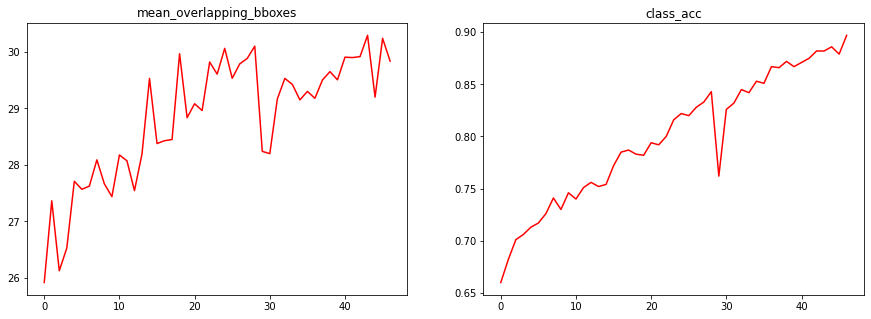

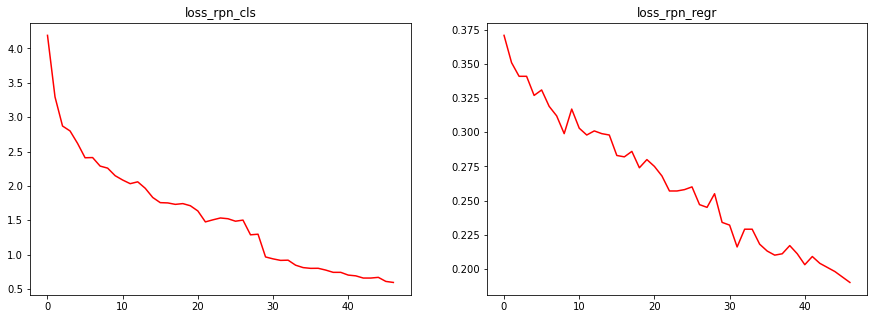

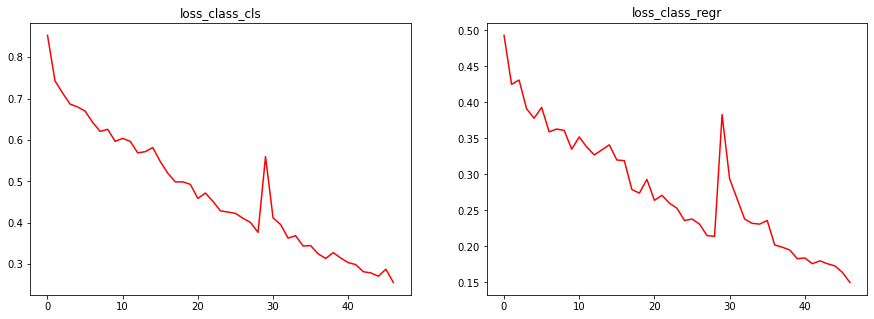

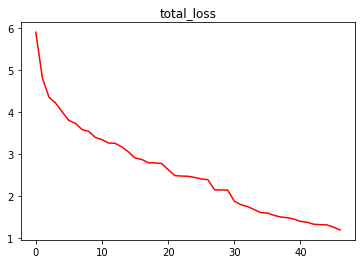

In [37]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['mean_overlapping_bboxes'], 'r')
plt.title('mean_overlapping_bboxes')
plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['class_acc'], 'r')
plt.title('class_acc')

plt.show()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_cls'], 'r')
plt.title('loss_rpn_cls')
plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_regr'], 'r')
plt.title('loss_rpn_regr')
plt.show()


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_cls'], 'r')
plt.title('loss_class_cls')
plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_regr'], 'r')
plt.title('loss_class_regr')
plt.show()

plt.plot(np.arange(0, r_epochs), record_df['curr_loss'], 'r')
plt.title('total_loss')
plt.show()

# plt.figure(figsize=(15,5))
# plt.subplot(1,2,1)
# plt.plot(np.arange(0, r_epochs), record_df['curr_loss'], 'r')
# plt.title('total_loss')
# plt.subplot(1,2,2)
# plt.plot(np.arange(0, r_epochs), record_df['elapsed_time'], 'r')
# plt.title('elapsed_time')
# plt.show()

# plt.title('loss')
# plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_cls'], 'b')
# plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_regr'], 'g')
# plt.plot(np.arange(0, r_epochs), record_df['loss_class_cls'], 'r')
# plt.plot(np.arange(0, r_epochs), record_df['loss_class_regr'], 'c')
# # plt.plot(np.arange(0, r_epochs), record_df['curr_loss'], 'm')
# plt.show()

In [38]:
tf.function(experimental_relax_shapes=True)
start_time = time.time()
for epoch_num in range(num_epochs):
  progbar = generic_utils.Progbar(epoch_length)
  print('Epoch {}/{}'.format(r_epochs + 1, total_epochs))
  r_epochs += 1
  while True:
    try:
      if len(rpn_accuracy_rpn_monitor) == epoch_length and config.verbose:
        mean_overlapping_bboxes = float(sum(rpn_accuracy_rpn_monitor))/len(rpn_accuracy_rpn_monitor)
        rpn_accuracy_rpn_monitor = []
        print('Average number of overlapping bounding boxes from RPN = {} for {} previous iterations'.format(mean_overlapping_bboxes, epoch_length))
        if mean_overlapping_bboxes == 0:
          print('RPN is not producing bounding boxes that overlap the ground truth boxes. Check RPN settings or keep training.')
      # Generate X (x_img) and label Y ([y_rpn_cls, y_rpn_regr])
      X, Y, img_data, debug_img, debug_num_pos = next(data_gen_train)
      # Train rpn model and get loss value [loss_rpn_cls, loss_rpn_regr]
      loss_rpn = model_rpn.train_on_batch(X, Y)
      # Get predicted rpn from rpn model [rpn_cls, rpn_regr]
      P_rpn = model_rpn.predict_on_batch(X)
      bboxes = rpn_to_roi(P_rpn[0], P_rpn[1], config)
      # note: calc_iou converts from (x1,y1,x2,y2) to (x,y,w,h) format
      # X2: bboxes that iou > config.classifier_min_overlap for all gt bboxes in 300 non_max_suppression bboxes
      # Y1: one hot code for bboxes from above => x_roi (X)
      # Y2: corresponding labels and corresponding gt bboxes
      X2, Y1, Y2, IoUs = convert_coor(bboxes, img_data, config, class_mapping)
      # If X2 is None means there are no matching bboxes
      if X2 is None:
        rpn_accuracy_rpn_monitor.append(0)
        rpn_accuracy_for_epoch.append(0)
        continue
      # Find out the positive anchors and negative anchors
      neg_samples = np.where(Y1[0, :, -1] == 1)
      pos_samples = np.where(Y1[0, :, -1] == 0)
      if len(neg_samples) > 0:
        neg_samples = neg_samples[0]
      else:
        neg_samples = []
      if len(pos_samples) > 0:
        pos_samples = pos_samples[0]
      else:
        pos_samples = []
      rpn_accuracy_rpn_monitor.append(len(pos_samples))
      rpn_accuracy_for_epoch.append((len(pos_samples)))
      if config.num_rois > 1:
        # If number of positive anchors is larger than 4//2 = 2, randomly choose 2 pos samples
        if len(pos_samples) < config.num_rois//2:
          selected_pos_samples = pos_samples.tolist()
        else:
          selected_pos_samples = np.random.choice(pos_samples, config.num_rois//2, replace=False).tolist()
         # Randomly choose (num_rois - num_pos) neg samples
        try:
          selected_neg_samples = np.random.choice(neg_samples, config.num_rois - len(selected_pos_samples), replace=False).tolist()
        except:
          selected_neg_samples = np.random.choice(neg_samples, config.num_rois - len(selected_pos_samples) if len(neg_samples)>0 else 0, replace=True).tolist()
        # Save all the pos and neg samples in sel_samples
        sel_samples = selected_pos_samples + selected_neg_samples
      else:
        # in the extreme case where num_rois = 1, we pick a random pos or neg sample
        selected_pos_samples = pos_samples.tolist()
        selected_neg_samples = neg_samples.tolist()
        if np.random.randint(0, 2):
          sel_samples = random.choice(neg_samples)
        else:
          sel_samples = random.choice(pos_samples)
      # training_data: [X, X2[:, sel_samples, :]]  
      # labels: [Y1[:, sel_samples, :], Y2[:, sel_samples, :]]
      #  X                     => img_data resized image
      #  X2[:, sel_samples, :] => num_rois (4 in here) bboxes which contains selected neg and pos
      #  Y1[:, sel_samples, :] => one hot encode for num_rois bboxes which contains selected neg and pos
      #  Y2[:, sel_samples, :] => labels and gt bboxes for num_rois bboxes which contains selected neg and pos
      loss_class = model_classifier.train_on_batch([X, X2[:, sel_samples, :]], [Y1[:, sel_samples, :], Y2[:, sel_samples, :]])
      losses[iter_num, 0] = loss_rpn[1]
      losses[iter_num, 1] = loss_rpn[2]
      
      losses[iter_num, 2] = loss_class[1]
      losses[iter_num, 3] = loss_class[2]
      losses[iter_num, 4] = loss_class[3]
      iter_num += 1
      progbar.update(iter_num, [('rpn_cls', np.mean(losses[:iter_num, 0])), ('rpn_regr', np.mean(losses[:iter_num, 1])),
                                      ('final_cls', np.mean(losses[:iter_num, 2])), ('final_regr', np.mean(losses[:iter_num, 3]))])
      if iter_num == epoch_length:
        loss_rpn_cls = np.mean(losses[:, 0])
        loss_rpn_regr = np.mean(losses[:, 1])
        loss_class_cls = np.mean(losses[:, 2])
        loss_class_regr = np.mean(losses[:, 3])
        class_acc = np.mean(losses[:, 4])
        mean_overlapping_bboxes = float(sum(rpn_accuracy_for_epoch)) / len(rpn_accuracy_for_epoch)
        rpn_accuracy_for_epoch = []
        if config.verbose:
          print('Mean number of bounding boxes from RPN overlapping ground truth boxes: {}'.format(mean_overlapping_bboxes))
          print('Classifier accuracy for bounding boxes from RPN: {}'.format(class_acc))
          print('Loss RPN classifier: {}'.format(loss_rpn_cls))
          print('Loss RPN regression: {}'.format(loss_rpn_regr))
          print('Loss Detector classifier: {}'.format(loss_class_cls))
          print('Loss Detector regression: {}'.format(loss_class_regr))
          print('Total loss: {}'.format(loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr))
          print('Elapsed time: {}'.format(time.time() - start_time))
          elapsed_time = (time.time()-start_time)/60
        curr_loss = loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr
        iter_num = 0
        start_time = time.time()
        if curr_loss < best_loss:
          if config.verbose:
            print('Total loss decreased from {} to {}, saving weights'.format(best_loss,curr_loss))
          best_loss = curr_loss
          model_all.save_weights(config.model_path)
        
          new_row = {'mean_overlapping_bboxes':round(mean_overlapping_bboxes, 3), 
              'class_acc':round(class_acc, 3), 
              'loss_rpn_cls':round(loss_rpn_cls, 3), 
              'loss_rpn_regr':round(loss_rpn_regr, 3), 
              'loss_class_cls':round(loss_class_cls, 3), 
              'loss_class_regr':round(loss_class_regr, 3), 
              
                     rr_loss':round(curr_loss, 3), 
              'elapsed_time':round(elapsed_time, 3), 
              'mAP': 0}
          record_df = record_df.append(new_row, ignore_index=True)
          record_df.to_csv(record_path, index=0)
          break
    except Exception as e:
      print('Exception: {}'.format(e))
      #continue
      break

print('Training complete, exiting.')

Epoch 48/57
   7/1000 [..............................] - ETA: 1:27:32 - rpn_cls: 4.5097 - rpn_regr: 0.0853 - final_cls: 0.2100 - final_regr: 0.0622WARNING:tensorflow:9 out of the last 9 calls to <function Model.make_train_function.<locals>.train_function at 0x7f0c5c0f2940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


  15/1000 [..............................] - ETA: 55:45 - rpn_cls: 3.4956 - rpn_regr: 0.1266 - final_cls: 0.2038 - final_regr: 0.0685WARNING:tensorflow:7 out of the last 11 calls to <function Model.make_train_function.<locals>.train_function at 0x7f0c5c0f2940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


  35/1000 [>.............................] - ETA: 35:16 - rpn_cls: 2.5890 - rpn_regr: 0.1425 - final_cls: 0.1982 - final_regr: 0.0807WARNING:tensorflow:5 out of the last 14 calls to <function Model.make_train_function.<locals>.train_function at 0x7f0c5c0f2940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


  44/1000 [>.............................] - ETA: 33:31 - rpn_cls: 2.3773 - rpn_regr: 0.1473 - final_cls: 0.2016 - final_regr: 0.0892WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_train_function.<locals>.train_function at 0x7f0c5c0f2940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


  54/1000 [>.............................] - ETA: 31:24 - rpn_cls: 2.1871 - rpn_regr: 0.1527 - final_cls: 0.2113 - final_regr: 0.0964WARNING:tensorflow:5 out of the last 11 calls to <function Model.make_train_function.<locals>.train_function at 0x7f0c5c0f2940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


  84/1000 [=>............................] - ETA: 27:33 - rpn_cls: 1.8264 - rpn_regr: 0.1604 - final_cls: 0.2210 - final_regr: 0.1075WARNING:tensorflow:6 out of the last 16 calls to <function Model.make_train_function.<locals>.train_function at 0x7f0c5c0f2940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 160/1000 [===>..........................] - ETA: 19:29 - rpn_cls: 1.4268 - rpn_regr: 0.1608 - final_cls: 0.2406 - final_regr: 0.1224WARNING:tensorflow:5 out of the last 11 calls to <function Model.make_train_function.<locals>.train_function at 0x7f0c5c0f2940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 166/1000 [===>..........................] - ETA: 19:58 - rpn_cls: 1.4074 - rpn_regr: 0.1611 - final_cls: 0.2417 - final_regr: 0.1236WARNING:tensorflow:7 out of the last 12 calls to <function Model.make_train_function.<locals>.train_function at 0x7f0c5c0f2940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 214/1000 [=====>........................] - ETA: 18:04 - rpn_cls: 1.2874 - rpn_regr: 0.1653 - final_cls: 0.2500 - final_regr: 0.1308WARNING:tensorflow:5 out of the last 15 calls to <function Model.make_train_function.<locals>.train_function at 0x7f0c5c0f2940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 322/1000 [========>.....................] - ETA: 13:55 - rpn_cls: 1.1404 - rpn_regr: 0.1704 - final_cls: 0.2602 - final_regr: 0.1392WARNING:tensorflow:5 out of the last 16 calls to <function Model.make_train_function.<locals>.train_function at 0x7f0c5c0f2940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 374/1000 [==========>...................] - ETA: 12:33 - rpn_cls: 1.0938 - rpn_regr: 0.1716 - final_cls: 0.2630 - final_regr: 0.1416WARNING:tensorflow:5 out of the last 12 calls to <function Model.make_train_function.<locals>.train_function at 0x7f0c5c0f2940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 566/1000 [===============>..............] - ETA: 8:04 - rpn_cls: 0.9847 - rpn_regr: 0.1751 - final_cls: 0.2649 - final_regr: 0.1443WARNING:tensorflow:6 out of the last 15 calls to <function Model.make_train_function.<locals>.train_function at 0x7f0c5c0f2940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


1000/1000 [==============================] - 988s 988ms/step - rpn_cls: 0.8814 - rpn_regr: 0.1773 - final_cls: 0.2635 - final_regr: 0.1486
Mean number of bounding boxes from RPN overlapping ground truth boxes: 29.966507177033492
Classifier accuracy for bounding boxes from RPN: 0.8905
Loss RPN classifier: 0.7271801605857309
Loss RPN regression: 0.18519080852740444
Loss Detector classifier: 0.2606367125077276
Loss Detector regression: 0.15602823667414487
Total loss: 1.3290359182950078
Elapsed time: 988.0440981388092
1000/1000 [==============================] - 1681s 2s/step - rpn_cls: 0.7599 - rpn_regr: 0.1911 - final_cls: 0.2546 - final_regr: 0.1486
Mean number of bounding boxes from RPN overlapping ground truth boxes: 30.170520231213874
Classifier accuracy for bounding boxes from RPN: 0.892
Loss RPN classifier: 0.6317614097782311
Loss RPN regression: 0.19054361731442623
Loss Detector classifier: 0.25420555464923583
Loss Detector regression: 0.15676144849602133
Total loss: 1.23327203023

1000/1000 [==============================] - 288s 288ms/step - rpn_cls: 0.6487 - rpn_regr: 0.1989 - final_cls: 0.2677 - final_regr: 0.1500
Mean number of bounding boxes from RPN overlapping ground truth boxes: 29.770334928229666
Classifier accuracy for bounding boxes from RPN: 0.896
Loss RPN classifier: 0.647942482911205
Loss RPN regression: 0.1904307258722838
Loss Detector classifier: 0.264102852404177
Loss Detector regression: 0.14962953800987452
Total loss: 1.2521055991975403
Elapsed time: 654.6273720264435
  44/1000 [>.............................] - ETA: 1:55:49 - rpn_cls: 0.6611 - rpn_regr: 0.1995 - final_cls: 0.2685 - final_regr: 0.1501Exception: in user code:

    /home/hnm942/anaconda3/envs/fast-rcnn/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    <ipython-input-29-5c5a1b9cddfe>:34 call  *
        x = rois[0, roi_idx, 0]
    /home/hnm942/anaconda3/envs/fast-rcnn/lib/python3.8/site-

1000/1000 [==============================] - 112s 112ms/step - rpn_cls: 0.5804 - rpn_regr: 0.1889 - final_cls: 0.2428 - final_regr: 0.1503
Mean number of bounding boxes from RPN overlapping ground truth boxes: 29.77151051625239
Classifier accuracy for bounding boxes from RPN: 0.90175
Loss RPN classifier: 0.5855305782325705
Loss RPN regression: 0.18686295066494496
Loss Detector classifier: 0.24004126516133448
Loss Detector regression: 0.14838262210600078
Total loss: 1.1608174161648506
Elapsed time: 591.5128877162933
Total loss decreased from 1.1909999999999998 to 1.1608174161648506, saving weights
Epoch 53/57
 535/1000 [===============>..............] - ETA: 4:37 - rpn_cls: 0.7190 - rpn_regr: 0.1698 - final_cls: 0.2716 - final_regr: 0.1565Exception: in user code:

    /home/hnm942/anaconda3/envs/fast-rcnn/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    <ipython-input-29-5c5a1b9cddfe>:34 call

1000/1000 [==============================] - 1788s 2s/step - rpn_cls: 0.6222 - rpn_regr: 0.1803 - final_cls: 0.2274 - final_regr: 0.1386
Mean number of bounding boxes from RPN overlapping ground truth boxes: 29.418957345971563
Classifier accuracy for bounding boxes from RPN: 0.899
Loss RPN classifier: 0.6299257103628371
Loss RPN regression: 0.18107422014288022
Loss Detector classifier: 0.24128157826285154
Loss Detector regression: 0.1442442237669602
Total loss: 1.196525732535529
Elapsed time: 598.0818469524384
1000/1000 [==============================] - 2372s 2s/step - rpn_cls: 0.6176 - rpn_regr: 0.1852 - final_cls: 0.2336 - final_regr: 0.1379
Mean number of bounding boxes from RPN overlapping ground truth boxes: 29.590996168582375
Classifier accuracy for bounding boxes from RPN: 0.8945
Loss RPN classifier: 0.5987510042771859
Loss RPN regression: 0.1839570599880535
Loss Detector classifier: 0.250462801568194
Loss Detector regression: 0.13928503556037322
Total loss: 1.1724559013938065
